## Solution Steps: 

1. Data access
2. Data exploration (initial data analysis)  
   2.1. Exploration of features and target distribution  
3. Data Preparation  
   3.1. Clean the data  
   3.2. Filter important features  
   3.3. Check for missing values     
   3.4. Feature engineering (feature creation, feature selection)  
4. Train the model
5. Use the model (Prediction)
6. Evaluate the model (accuracy)

## **Import Libraries**

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import zscore,norm
from sklearn.model_selection import train_test_split
from IPython.display import display
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import random
from sklearn.metrics import median_absolute_error
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import shuffle
import pickle
import warnings
warnings.filterwarnings('ignore')

## **Data Access** ##

In [27]:
# Load dataset
dataset =  pd.ExcelFile("Eurasian - Dataset_tims.xlsx")
Eurasian = pd.read_excel(dataset, 'Eurasian')

# Extract relevant columns
Ancients = Eurasian[['AncientComponent1', 'AncientComponent2','AncientComponent3', 
                     'AncientComponent4', 'AncientComponent5', 'ModernComponent1',
                     'ModernComponent2', 'ModernComponent3', 
                     'Date mean in BP in years before 1950 CE [OxCal mu for a direct radiocarbon date, and average of range for a contextual date]',
                     'Method for Determining Date; unless otherwise specified, calibrations use 95.4% intervals from OxCal v4.4.2 Bronk Ramsey (2009); r:5; Atmospheric data from Reimer et al (2020)',
                     'Sample ID', 'Country',
                     'Date standard deviation in BP [OxCal sigma for a direct radiocarbon date, and standard deviation of the uniform disribution between the two bounds for a contextual date]']]

# Rename columns for clarity
Ancients.rename(columns={
    'Method for Determining Date; unless otherwise specified, calibrations use 95.4% intervals from OxCal v4.4.2 Bronk Ramsey (2009); r:5; Atmospheric data from Reimer et al (2020)': 'Dating',
    'Date standard deviation in BP [OxCal sigma for a direct radiocarbon date, and standard deviation of the uniform disribution between the two bounds for a contextual date]': 'STD',
    'Date mean in BP in years before 1950 CE [OxCal mu for a direct radiocarbon date, and average of range for a contextual date]': 'Mean date (BP)'
}, inplace=True)

# Load and process modern samples
modern = pd.read_csv('Eurasian_modern_samples.csv')
modern = modern[['AncientComponent1', 'AncientComponent2','AncientComponent3',
                 'AncientComponent4', 'AncientComponent5', 'ModernComponent1',
                 'ModernComponent2', 'ModernComponent3', 'DateBP', 'Sample ID']]
modern.rename(columns={'DateBP': 'Mean date (BP)'}, inplace=True)

# Load and process modern samples' annotation
modern_annotation = pd.read_excel("20130606_sample_info.xlsx")
modern_annotation.rename(columns={'Sample': 'Sample ID', 'Population': 'Country'}, inplace=True)
Moderns = pd.merge(modern_annotation, modern, on=["Sample ID"])
Moderns['Dating'] = np.nan
Moderns = Moderns[['AncientComponent1', 'AncientComponent2','AncientComponent3', 
                   'AncientComponent4', 'AncientComponent5', 'ModernComponent1',
                   'ModernComponent2', 'ModernComponent3', 'Mean date (BP)', 
                   'Dating', 'Sample ID', 'Country']]

# Load test cases
test_cases = pd.ExcelFile("Test Cases.xlsx")
Brandysek_inds = pd.read_excel(test_cases, 'Brandysek inds')
Brandysek_inds = Brandysek_inds.iloc[0:14,:]
Brandysek_inds.rename(columns={'Version ID':'Sample ID'}, inplace=True)

# Update modern samples
Moderns['STD'] = 0

# Load and process viking dataset
viking_df = pd.read_csv('Viking Dates.txt', sep="\t")
viking_df.rename(columns={'mean ( arch date+ 14C )': 'Mean date (BP)'}, inplace=True)

# Load Reich dataset
Reich = pd.read_excel('Reich_new_first.xlsx')

# Check for matching samples between Reich and Viking datasets
bool_series = Reich['Master ID'].isin(viking_df['Sample'])

# Extract matching samples
matching_samples = Reich[bool_series]

# Describe span data from viking dataset
viking_df[['span (-+) (arch + 14C date)']].describe()

,span (-+) (arch + 14C date)
count,29.000000
mean,87.258621
std,34.096141
min,30.000000
25%,54.000000
50%,95.000000
75%,125.000000
max,125.000000


In [28]:
# Rename the long column name for simplicity
matching_samples.rename(columns={
    'Date standard deviation in BP [OxCal sigma for a direct radiocarbon date, and standard deviation of the uniform distribution between the two bounds for a contextual date]': 'Date_STD_BP'
}, inplace=True)

# Now describe the data
matching_samples[['Date_STD_BP']].describe()


,Date_STD_BP
count,29.000000
mean,71.000000
std,17.784423
min,29.000000
25%,67.000000
50%,68.000000
75%,87.000000
max,87.000000


In [29]:
# Define the file path
Q = r'mergev.8.Q'

# Define the column names
column_names = ['AncientComponent1', 'AncientComponent2', 'AncientComponent3', 
                'AncientComponent4', 'AncientComponent5', 'ModernComponent1',
                'ModernComponent2', 'ModernComponent3']

# Read the data from the file
vikings_cmps = pd.read_csv(Q, sep=' ', names=column_names)

# Exclude the first 120 "zombie" rows
vikings_cmps = vikings_cmps.iloc[120:] 

# Reset the index of the DataFrame
vikings_cmps = vikings_cmps.reset_index(drop=True)

# Extract subset from viking_df and reset its index
subset_viking_df = viking_df[['Sample', 'Mean date (BP)']].reset_index(drop=True)

# Concatenate vikings_cmps and subset_viking_df along the columns
vikings = pd.concat([vikings_cmps, subset_viking_df], axis=1)

# Rename the column for clarity
vikings.rename(columns={'Sample': 'Sample ID'}, inplace=True)



## **Data Exploration (Initial Data Analysis)** ##

In [30]:
print(Ancients.info())
display(Ancients.head(3))
print(Moderns.info())
display(Moderns.head(3))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4158 entries, 0 to 4157
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   AncientComponent1  4158 non-null   float64
 1   AncientComponent2  4158 non-null   float64
 2   AncientComponent3  4158 non-null   float64
 3   AncientComponent4  4158 non-null   float64
 4   AncientComponent5  4158 non-null   float64
 5   ModernComponent1   4158 non-null   float64
 6   ModernComponent2   4158 non-null   float64
 7   ModernComponent3   4158 non-null   float64
 8   Mean date (BP)     4158 non-null   int64  
 9   Dating             4158 non-null   object 
 10  Sample ID          4158 non-null   object 
 11  Country            4158 non-null   object 
 12  STD                4158 non-null   int64  
dtypes: float64(8), int64(2), object(3)
memory usage: 422.4+ KB
None


,AncientComponent1,AncientComponent2,AncientComponent3,AncientComponent4,AncientComponent5,ModernComponent1,ModernComponent2,ModernComponent3,Mean date (BP),Dating,Sample ID,Country,STD
0,0.000011,0.000010,0.999929,0.000010,0.00001,0.000010,0.00001,0.000010,5162,Direct: IntCal20,I1658,Armenia,80
1,0.243402,0.025254,0.009610,0.136992,0.00001,0.009278,0.56163,0.013823,5166,Direct: IntCal20,1H07.SG,France,79
2,0.255344,0.017537,0.000010,0.095890,0.00001,0.011373,0.60052,0.019316,4950,Direct: IntCal20,1H13.SG,France,53


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1307 entries, 0 to 1306
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   AncientComponent1  1307 non-null   float64
 1   AncientComponent2  1307 non-null   float64
 2   AncientComponent3  1307 non-null   float64
 3   AncientComponent4  1307 non-null   float64
 4   AncientComponent5  1307 non-null   float64
 5   ModernComponent1   1307 non-null   float64
 6   ModernComponent2   1307 non-null   float64
 7   ModernComponent3   1307 non-null   float64
 8   Mean date (BP)     1307 non-null   int64  
 9   Dating             0 non-null      float64
 10  Sample ID          1307 non-null   object 
 11  Country            1307 non-null   object 
 12  STD                1307 non-null   int64  
dtypes: float64(9), int64(2), object(2)
memory usage: 132.9+ KB
None


,AncientComponent1,AncientComponent2,AncientComponent3,AncientComponent4,AncientComponent5,ModernComponent1,ModernComponent2,ModernComponent3,Mean date (BP),Dating,Sample ID,Country,STD
0,0.066929,0.040100,0.003131,0.035866,0.014960,0.001272,0.822988,0.014754,10,NaN,HG00096,GBR,0
1,0.073446,0.047749,0.002356,0.030496,0.007208,0.005035,0.819372,0.014338,10,NaN,HG00097,GBR,0
2,0.066791,0.052471,0.000010,0.031622,0.013156,0.003371,0.826157,0.006421,10,NaN,HG00099,GBR,0


((array([-3.58788103, -3.34962434, -3.21815727, ...,  3.21815727,
          3.34962434,  3.58788103]),
  array([  90,  124,  126, ..., 9933, 9952, 9992], dtype=int64)),
 (1952.5463041633557, 3925.416305916306, 0.9865907741315157))

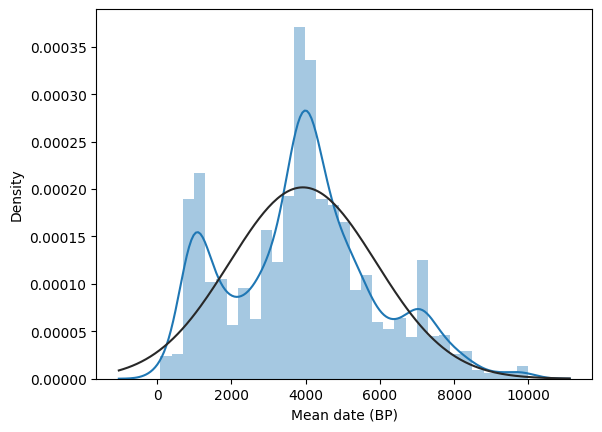

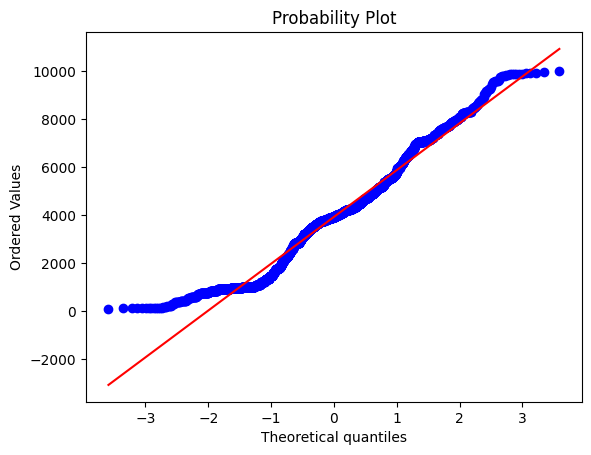

In [31]:
sns.distplot(Ancients['Mean date (BP)'], fit = norm) # A frequency distribution plot and the maximum likelihood Gaussian distribution fit
fig = plt.figure()
stats.probplot(Ancients['Mean date (BP)'], plot=plt) # It generates a probability plot of sample data against the quantiles of a specified theoretical distribution (the normal distribution by default).

## **Clean the Data**

In [32]:
def outlier_by_zscore(df:pd.DataFrame, column, outliers):
    df['is_outlier'] = zscore(df[column])
    is_outlier = df['is_outlier'].apply(lambda x: x <= -3 or x >= 3)
    df.drop('is_outlier',axis=1,inplace=True)
    return df[~is_outlier], pd.concat([outliers, df[is_outlier]])

def preprocess(df:pd.DataFrame, outliers):
    df, outliers = outlier_by_zscore(df,'Mean date (BP)', outliers)
    df, outliers = outlier_by_zscore(df,'AncientComponent1', outliers)  
    df, outliers = outlier_by_zscore(df,'AncientComponent2', outliers)
    df, outliers = outlier_by_zscore(df,'AncientComponent3', outliers) 
    df, outliers = outlier_by_zscore(df,'AncientComponent4', outliers)
    df, outliers = outlier_by_zscore(df,'AncientComponent5', outliers)
    df, outliers = outlier_by_zscore(df,'ModernComponent1', outliers)
    df, outliers = outlier_by_zscore(df,'ModernComponent2', outliers)
    df, outliers = outlier_by_zscore(df,'ModernComponent3', outliers)

    outliers11 = df[df.STD >= 400]
    outliers = pd.concat([outliers, outliers11])
    df = df[df.STD < 400]
    return df, outliers

outliers:pd.DataFrame = pd.DataFrame()
Ancients, outliers = preprocess(Ancients, outliers)


## **Check for Missing Values** 

In [33]:
print(Ancients.isnull().sum()) # No missing values are found
print(Moderns.isnull().sum()) # No missing values are found, Their Datings are intentionally left blank.

AncientComponent1    0
AncientComponent2    0
AncientComponent3    0
AncientComponent4    0
AncientComponent5    0
ModernComponent1     0
ModernComponent2     0
ModernComponent3     0
Mean date (BP)       0
Dating               0
Sample ID            0
Country              0
STD                  0
dtype: int64
AncientComponent1       0
AncientComponent2       0
AncientComponent3       0
AncientComponent4       0
AncientComponent5       0
ModernComponent1        0
ModernComponent2        0
ModernComponent3        0
Mean date (BP)          0
Dating               1307
Sample ID               0
Country                 0
STD                     0
dtype: int64


## **Feature Engineering**

In [34]:
# List of column names for calculation
ancient_columns = ['AncientComponent1', 'AncientComponent2', 'AncientComponent3',
                   'AncientComponent4', 'AncientComponent5']

# Calculate mean for ancient columns for 'Ancients' DataFrame
Ancients['mean_Ancient_columns'] = Ancients[ancient_columns].mean(axis=1)

# Compute the mean of 'AncientComponent1' for 'Ancients' DataFrame
AncientComponent1_mean = Ancients['AncientComponent1'].mean()

# Calculate the absolute difference from mean for 'AncientComponent1' and update it
Ancients['AncientComponent1_diff_mean'] = abs(Ancients['AncientComponent1'] - AncientComponent1_mean)
Ancients['AncientComponent1'] += 3 * Ancients['AncientComponent1_diff_mean']

# Repeat the process for 'Moderns' DataFrame
Moderns['mean_Ancient_columns'] = Moderns[ancient_columns].mean(axis=1)
Moderns['AncientComponent1_diff_mean'] = abs(Moderns['AncientComponent1'] - AncientComponent1_mean)
Moderns['AncientComponent1'] += 3 * Moderns['AncientComponent1_diff_mean']

# Repeat the process for 'vikings' DataFrame
vikings['mean_Ancient_columns'] = vikings[ancient_columns].mean(axis=1)

# Compute the mean of 'AncientComponent1' for 'vikings' DataFrame
AncientComponent1_mean = vikings['AncientComponent1'].mean()

vikings['AncientComponent1_diff_mean'] = abs(vikings['AncientComponent1'] - AncientComponent1_mean)
vikings['AncientComponent1'] += 3 * vikings['AncientComponent1_diff_mean']


## **Split the Data**

 ## **Train_set, Test_set (unseen)**

In [35]:
# Read the excel file
test_published = pd.read_excel('test_published.xlsx')

# Concatenate the Moderns and Ancients datasets
merged_df = pd.concat([Moderns, Ancients], ignore_index=True)

# Get the Sample IDs from test_published
test_published_ids = test_published['Sample ID']

# Create the test set by filtering rows in the merged dataframe where Sample ID exists in test_published
test_set = merged_df[merged_df['Sample ID'].isin(test_published_ids)]

# Create the train set by filtering rows in the merged dataframe where Sample ID does NOT exist in test_published
train_set = merged_df[~merged_df['Sample ID'].isin(test_published_ids)]


In [36]:
# Remove 'Dating', 'Country', and 'STD' columns from train_set
train_set = train_set[train_set.columns.difference(['Dating', 'Country', 'STD'])]

# Append 'vikings' DataFrame to 'train_set'
train_set = pd.concat([train_set, vikings])

# Copy the 'train_set' DataFrame to 'train_set1'
train_set1 = train_set.copy()

# Remove 'Sample ID' column from 'train_set'
train_set = train_set[train_set.columns.difference(['Sample ID'])]

# Copy 'test_set' DataFrame to 'test_set1'
test_set1 = test_set.copy()

# Remove 'Sample ID', 'Dating', 'Country', and 'STD' columns from 'test_set'
test_set = test_set[test_set.columns.difference(['Sample ID', 'Dating', 'Country', 'STD'])]

# Define features (X) and target (y) for training data
X_train = train_set[train_set.columns.difference(['Mean date (BP)'])]
y_train = train_set['Mean date (BP)']

# Define features (X) and target (y) for test data
X_test = test_set[test_set.columns.difference(['Mean date (BP)'])]
y_test = test_set['Mean date (BP)']

# Print the shape of the train_set and test_set
print('Data for Modeling: ' + str(train_set.shape))
print('Unseen Data For Predictions: ' + str(test_set.shape))


Data for Modeling: (4187, 11)
Unseen Data For Predictions: (740, 11)


 ## **Train the Model**

In [37]:
from sklearn.metrics import median_absolute_error
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import shuffle

def cross_validation(df, target, k=10):
    # Preparing Data
    X = df.drop(target,axis=1).values
    y = df[target].values
    X, y = shuffle(X, y, random_state=42)  # Shuffle data

    # Initializing variables
    best_MedAE = float('inf')  # Starting with a large number
    best_model = None
    best_train_data = None
    best_val_data = None
    best_random_state = None

    # Cross Validation Process
    for random_state in [32]:  # Using a specific seed
        kf = KFold(n_splits=k, shuffle=False)
        rf_reg = RandomForestRegressor(max_depth=20, random_state=random_state)

        for train_index, val_index in kf.split(X):
            # Splitting data into train and validation sets
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]

            # Training model and making prediction
            rf_reg.fit(X_train, y_train)
            y_val_pred = rf_reg.predict(X_val)

            # Calculating error
            this_k_MedAE = median_absolute_error(y_val, y_val_pred)

            # Checking and updating best results
            if this_k_MedAE < best_MedAE:
                best_MedAE = this_k_MedAE
                best_model = rf_reg
                best_train_data = (X_train, y_train)
                best_val_data = (X_val, y_val)
                best_random_state = random_state

    return best_model, best_MedAE, best_train_data, best_val_data, best_random_state

# Running cross validation
best_model, best_MedAE, best_train_data, best_val_data, best_random_state = cross_validation(df=train_set, target='Mean date (BP)', k=10)

# Assigning best data for future use
X_train_best, y_train_best = best_train_data
X_val_best, y_val_best = best_val_data

# Displaying results
print("The best median absolute error is: ", best_MedAE)
print("The best random state is: ", best_random_state)


The best median absolute error is:  189.62495154553017
The best random state is:  32


 ## **Prediction**

In [38]:
# Use the best model to make predictions
loaded_model = best_model

# Create a copy of the test set
test_predictions = X_test.copy()

# Append the actual dates to the test predictions dataframe
test_predictions['Mean date (BP)'] = y_test.astype('float')

# Generate predictions using the model and append them to the dataframe
test_predictions['TPS predicted date (BP)'] = loaded_model.predict(X_test).round()

# Combine additional information from the original test set
test_predictions = pd.concat([test_set1[['Sample ID', 'Country', 'Dating']], test_predictions], axis=1)

# Calculate the absolute difference between the predicted and actual dates
test_predictions["difference"] = abs(test_predictions['TPS predicted date (BP)'] - test_predictions['Mean date (BP)'])

test_predictions.to_excel("test_VikingsWereInTrain.xlsx")

## **Evaluation**

In [39]:
def evaluate(y, yhat, model, X):
    mae = metrics.mean_absolute_error(y, yhat)
    mse = metrics.mean_squared_error(y, yhat)
    rmse = np.sqrt(metrics.mean_squared_error(y, yhat))
    r2_square = model.score(X, y)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('__________________________________')

test_pred = loaded_model.predict(X_test)
train_pred = loaded_model.predict(X_train)

print('Test set evaluation:\n_____________________________________')
evaluate(y_test, test_pred, loaded_model, X_test)

print('Train set evaluation:\n_____________________________________')
evaluate(y_train, train_pred, loaded_model, X_train)    

Test set evaluation:
_____________________________________
MAE: 494.11925036378386
MSE: 675261.6847457999
RMSE: 821.7430770902788
R2 Square 0.8690011481395894
__________________________________
Train set evaluation:
_____________________________________
MAE: 227.51788291384835
MSE: 160362.2038546374
RMSE: 400.45249887425774
R2 Square 0.969138470443341
__________________________________


In [40]:
test_predictions['difference'].describe()

count     740.000000
mean      494.122973
std       657.038525
min         0.000000
25%        34.000000
50%       250.500000
75%       688.500000
max      4565.000000
Name: difference, dtype: float64

In [41]:
# Create a new dataframe by selecting rows in test_predictions where 'Sample ID' starts with "VK" or "vik" (Vikings)
df_VK_vik = test_predictions[test_predictions['Sample ID'].str.startswith(("VK", "vik"))]

# Display summary statistics of the 'difference' column in the new dataframe
df_VK_vik['difference'].describe()


count      58.000000
mean      391.344828
std       531.823297
min        13.000000
25%        70.500000
50%       142.000000
75%       486.000000
max      2338.000000
Name: difference, dtype: float64